## FATES ensemble of maintenance respiration 

### Libraries

In [1]:
import numpy as np
import xarray as xr
import csv
import pandas as pd

import functions_py.fates_xarray_functions as fa

import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
from matplotlib import cm
import matplotlib.colors as mcolors

import cartopy.mpl.ticker as cticker
import cartopy.crs as ccrs

import networkx as nx

### Distance  functions

In [2]:
# Euclidean distance between each plot and grid cell midpoints 
# Should maybe account for curvature of the earth? Or maybe unimportant since we are using a 4x5 grid?
def get_euclidian_distance(x1,x2,y1,y2):
    dist = ( (abs(x1-x2))**2 + (abs(y1-y2))**2)**(1/2)
    return dist

def find_nearest_grid(lat,lon, mid_lats, mid_lons, fates_fracs):
    n_lat = len(mid_lats)
    n_lon = len(mid_lons)
    
    count = 0
    site_dists = np.empty((n_lat * n_lon))
    site_dists[:] = np.NaN
    min_index = np.empty((2))
    
    for i in range(0, n_lat):
        for j in range(0, n_lon):
       
            dist_ij = get_euclidian_distance(lat, mid_lats[i], lon, mid_lons[j])
            site_dists[count] = dist_ij
        
            if np.nanmin(site_dists) == dist_ij :
                if not np.isnan(fates_fracs[i,j]):
                    min_index[0] = i
                    min_index[1] = j
            
            count = count + 1
    return min_index


### Load FATES  runs

In [3]:
ninst = 9

# Loop through the ensemble members 
fates_runs =  [None] * ninst

for i in range(0,ninst):
    fates_file = '/compyfs/need138/elm_runs/m20_ensemble_%d.Ec63cce2-F612413c.m20_ensemble_%d.2022-11-08/run/lnd/hist/m20_ensemble_%d.Ec63cce2-F612413c.m20_ensemble_%d.2022-11-08.elm.h0.fullrun.nc' % (i,i,i,i)
    fates_runs[i] = xr.open_dataset(fates_file, decode_times=False)
    
nyears = int(len(fates_runs[0].variables['time'])/12)

n_lat = len(fates_runs[0].variables['lat'])
n_lon = len(fates_runs[0].variables['lon'])

tave_start = (nyears-5)*12
tave_stop = nyears*12

cohort_size_bins = fates_runs[0].variables['fates_levscls'][:]
nsizebins = len(cohort_size_bins)
    


### fates_base_mr_20 values

In [4]:
default = 2.52e-06
minp = default * 0.5
maxp = default * 2.5
n = 9
mr20s = np.linspace(minp, maxp, n)
print(mr20s)

[1.26e-06 1.89e-06 2.52e-06 3.15e-06 3.78e-06 4.41e-06 5.04e-06 5.67e-06
 6.30e-06]


### NPP/GPP - maps

Text(0.5, 0.98, 'NPP/GPP  fates_m20 ensemble')

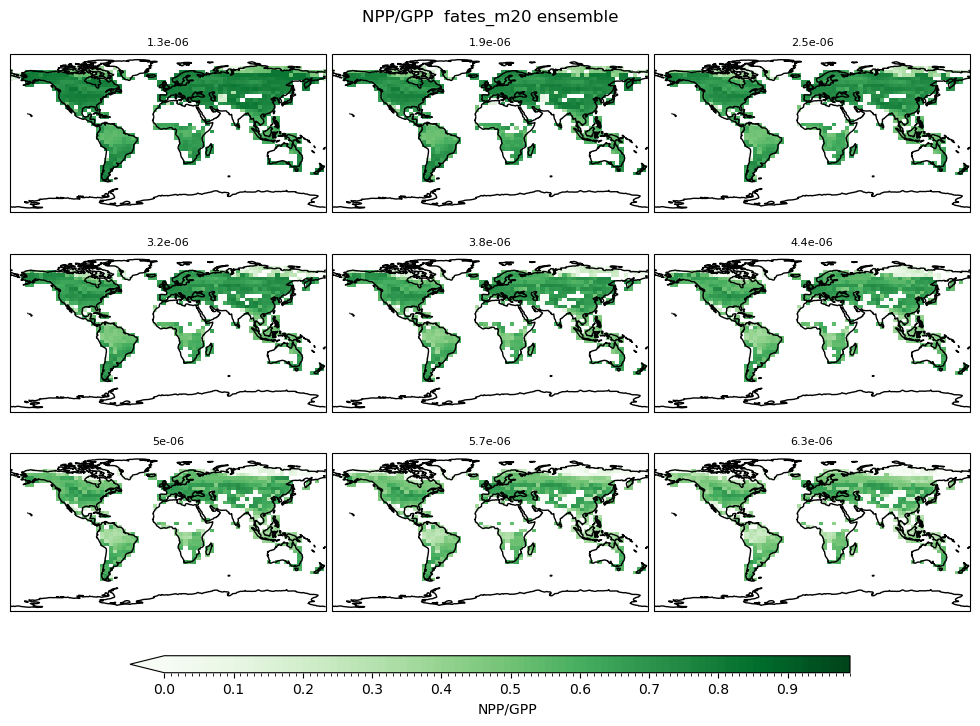

In [5]:
fig, axs = plt.subplots(nrows=3,ncols=3,
                        subplot_kw={'projection': ccrs.PlateCarree()},
                        figsize=(12,8.5))

clevs = np.arange(0.,1,0.01)

axs=axs.flatten()

for i in range(0,ninst):
    gpp  = fates_runs[i].FATES_GPP.isel(time=slice(tave_start,tave_stop)).mean(dim='time')
    npp  = fates_runs[i].FATES_NPP.isel(time=slice(tave_start,tave_stop)).mean(dim='time')
    npp_gpp =  npp/gpp
    
    cs = npp_gpp.plot(levels=clevs, transform=ccrs.PlateCarree(),cmap='Greens', ax=axs[i],
                     add_colorbar=False)
    axs[i].coastlines()
    axs[i].set_title('%s' % float('%.2g' % mr20s[i]), fontsize=8)
    

#fig.subplots_adjust(right =0.82)    
fig.subplots_adjust(bottom=0.25, top=0.95, left=0.1, right=0.9,
                    wspace=0.02, hspace=0.02)

# Add a colorbar axis at the bottom of the graph
cbar_ax = fig.add_axes([0.2, 0.2, 0.6, 0.02])

# Draw the colorbar
cbar=fig.colorbar(cs, cax=cbar_ax, orientation='horizontal')
cbar.set_label('NPP/GPP', fontsize=10)


# Add a big title at the top
plt.suptitle('NPP/GPP  fates_m20 ensemble')

### AWP maps

Text(0.5, 0.98, 'AWP')

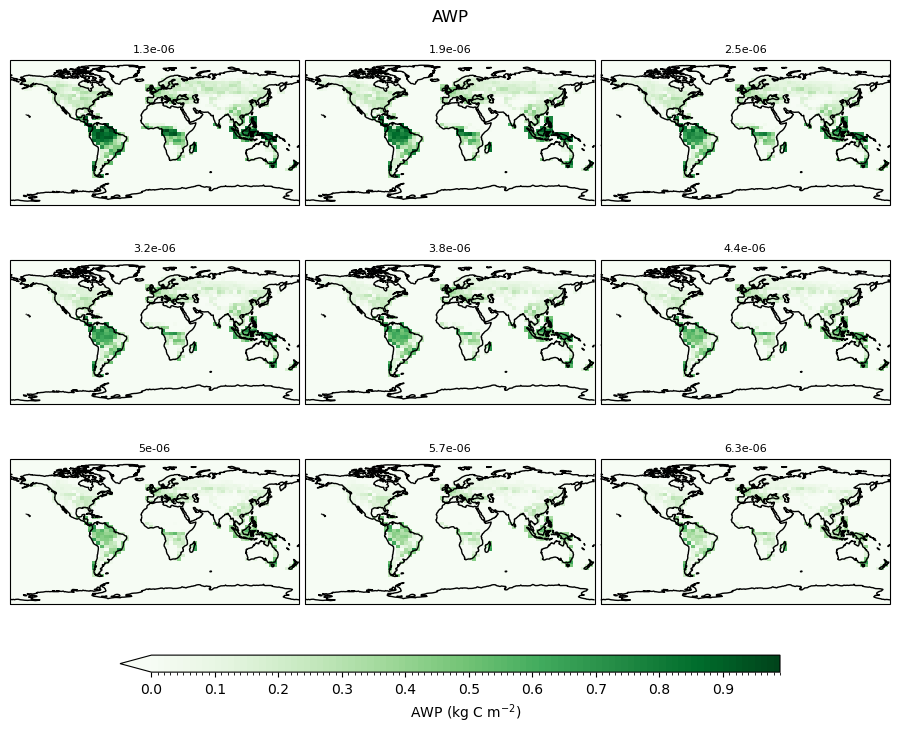

In [6]:
fig, axs = plt.subplots(nrows=3,ncols=3,
                        subplot_kw={'projection': ccrs.PlateCarree()},
                        figsize=(11,8.5))

clevs = np.arange(0.,1,0.01)

axs=axs.flatten()

for i in range(0,ninst):
    awp_szpf = fates_runs[i].FATES_ABOVEGROUND_PROD_SZPF.isel(time=slice(tave_start,tave_stop)).mean(dim='time') * 86400 * 365
    awp = awp_szpf.sum(dim='fates_levscpf')

    cs = awp.plot(levels=clevs, transform=ccrs.PlateCarree(),cmap='Greens', ax=axs[i],
                     add_colorbar=False)
    axs[i].coastlines()
    axs[i].set_title('%s' % float('%.2g' % mr20s[i]), fontsize=8)
    
    
fig.subplots_adjust(bottom=0.25, top=0.95, left=0.1, right=0.9,
                    wspace=0.02, hspace=0.02)

# Add a colorbar axis at the bottom of the graph
cbar_ax = fig.add_axes([0.2, 0.2, 0.6, 0.02])

# Draw the colorbar
cbar=fig.colorbar(cs, cax=cbar_ax, orientation='horizontal')
cbar.set_label(r'AWP (kg C m$^{-2}$)', fontsize=10)


# Add a big title at the top
plt.suptitle('AWP')

### NPP/GPP - scatter plot
Plot npp/gpp at BCI PFT 1 for each levev of mr_20

In [7]:
# Load plot data containing lat and lon for each plot. 
# Remove Hawaii since it is just water  in a 4x5 res plot
total_data = pd.read_csv('/qfs/people/need138/plot_data/Piponiot_2022_totals.csv')
total_data =  total_data[total_data.Site != 'Laupahoehoe']
total_data =  total_data[total_data.Site != 'Palamanui']

sites = np.array(total_data['Site'])
lat = np.array(total_data['Lat'])
lon_negs = np.array(total_data['Lon'])
lon = [x%360 for x in lon_negs]

# Mid points of each grid cell
range_lat = 180
range_lon = 360
width_lat = range_lat/n_lat
width_lon = range_lon/n_lon
min_lat = fates_runs[0].coords['lat'][0]
min_lon = fates_runs[0].coords['lon'][0]
min_mid_lat = min_lat + width_lat/2
min_mid_lon = min_lon + width_lon/2

mid_lat = min_mid_lat.values + (width_lat * np.arange(n_lat))
mid_lon = min_mid_lon.values + (width_lon * np.arange(n_lon))

n_plots=len(lat) # number of forestGEO sites
min_grids = np.empty((n_plots,2),int) # array to hold index of nearest grid cells for each plot

# Check fates frac in the selected grid cell. If it is NA then pick the next nearest grid cell. 
fates_frac = fates_runs[1].FATES_FRACTION.isel(time=0).values

# Find  grid cell closest to each ForestGEO  plot
for k in range(0, n_plots) :
    min_grids[k,:] = find_nearest_grid(lat[k], lon[k], mid_lat, mid_lon, fates_frac)
    
# get indeces
lat_ind = min_grids[:,0]
lon_ind = min_grids[:,1]
    
# These are on a -90 to 90 and 0 to 360 scale
plot_mid_lats = mid_lat[lat_ind]
plot_mid_lons = mid_lon[lon_ind]

# Transform back to -90 to 90 and -180 to 180 for plotting
fig_plot_mid_lats = plot_mid_lats
fig_plot_mid_lons = [-1*(360-x) if x > 180 else x for x in plot_mid_lons]


In [8]:
colormap = cm.viridis
normalize = mcolors.Normalize(vmin=np.min(lat), vmax=np.max(lat))
s_map = cm.ScalarMappable(norm=normalize, cmap=colormap)

(9, 23)


''

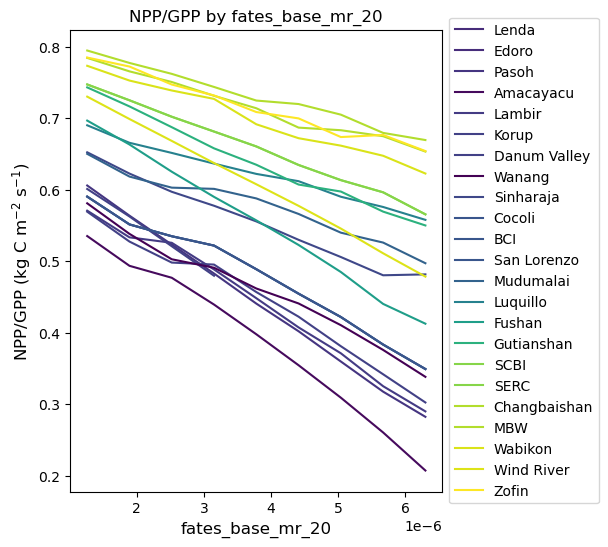

In [9]:
# NPP/GPP  for  each forest geo plot
x = xr.DataArray(lat_ind, dims = ['location'])
y = xr.DataArray(lon_ind, dims = ['location'])

npp_gpp = np.empty(shape=(ninst, n_plots), dtype='object')
print(npp_gpp.shape)

for i in range(0,ninst):
    npp = fates_runs[i].FATES_NPP.isel(time=slice(tave_start,tave_stop)).mean(dim='time')
    npp = npp.isel(lat=x,lon=y)
    gpp = fates_runs[i].FATES_GPP.isel(time=slice(tave_start,tave_stop)).mean(dim='time')
    gpp = gpp.isel(lat=x,lon=y)
    tmp = npp/gpp
    npp_gpp[i,:] = npp/gpp
    

fig2, ((f2ax0)) = plt.subplots(nrows=1,ncols=1, figsize=(6,6))

for i in range(0,n_plots):
    f2ax0.plot(mr20s, npp_gpp[:,i], label = sites[i], color=s_map.to_rgba(lat[i]))  
    

f2ax0.set_title(r'NPP/GPP by fates_base_mr_20', fontsize = 12)
f2ax0.set_ylabel(r'NPP/GPP (kg C m$^{-2}$ s$^{-1}$)', fontsize = 12)
f2ax0.set_xlabel(r'fates_base_mr_20', fontsize = 12)    
   
# Shrink current axis by 20%
box = f2ax0.get_position()
f2ax0.set_position([box.x0, box.y0, box.width * 0.8, box.height])

# Put a legend to the right of the current axis
f2ax0.legend(loc='center left', bbox_to_anchor=(1, 0.5), fontsize = 10)

;

### AWP  FATES  v ForestGEO for each level of mr_20

In [10]:
# AWP
plot_awp = np.array(total_data['AWP'])
# Mg ha-1 of biomass to kg m-2 of Carbon  
plot_awp = plot_awp * 1000 / 10000 / 2 
# uncertainties
plot_awp_l = np.array(total_data['AWP_l'])
plot_awp_l  = plot_awp_l * 1000 / 10000 / 2
plot_awp_l = plot_awp - plot_awp_l
plot_awp_u = np.array(total_data['AWP_u'])
plot_awp_u  = plot_awp_u * 1000 / 10000 / 2
plot_awp_u = plot_awp_u - plot_awp

# AWM
plot_awm = np.array(total_data['AWM'])
# Mg ha-1 of biomass to kg m-2 of Carbon  
plot_awm = plot_awm * 1000 / 10000 / 2 
# uncertainties
plot_awm_l = np.array(total_data['AWM_l'])
plot_awm_l  = plot_awm_l * 1000 / 10000 / 2
plot_awm_l = plot_awm - plot_awm_l
plot_awm_u = np.array(total_data['AWM_u'])
plot_awm_u  = plot_awm_u * 1000 / 10000 / 2
plot_awm_u = plot_awm_u - plot_awm

# AGB
plot_agb = np.array(total_data['AGB'])
# Mg ha-1 of biomass to kg m-2 of Carbon  
plot_agb = plot_agb * 1000 / 10000 / 2 
# uncertainties
plot_agb_l = np.array(total_data['AGB_l'])
plot_agb_l  = plot_agb_l * 1000 / 10000 / 2
plot_agb_l = plot_agb - plot_agb_l
plot_agb_u = np.array(total_data['AGB_u'])
plot_agb_u  = plot_agb_u * 1000 / 10000 / 2
plot_agb_u = plot_agb_u - plot_agb


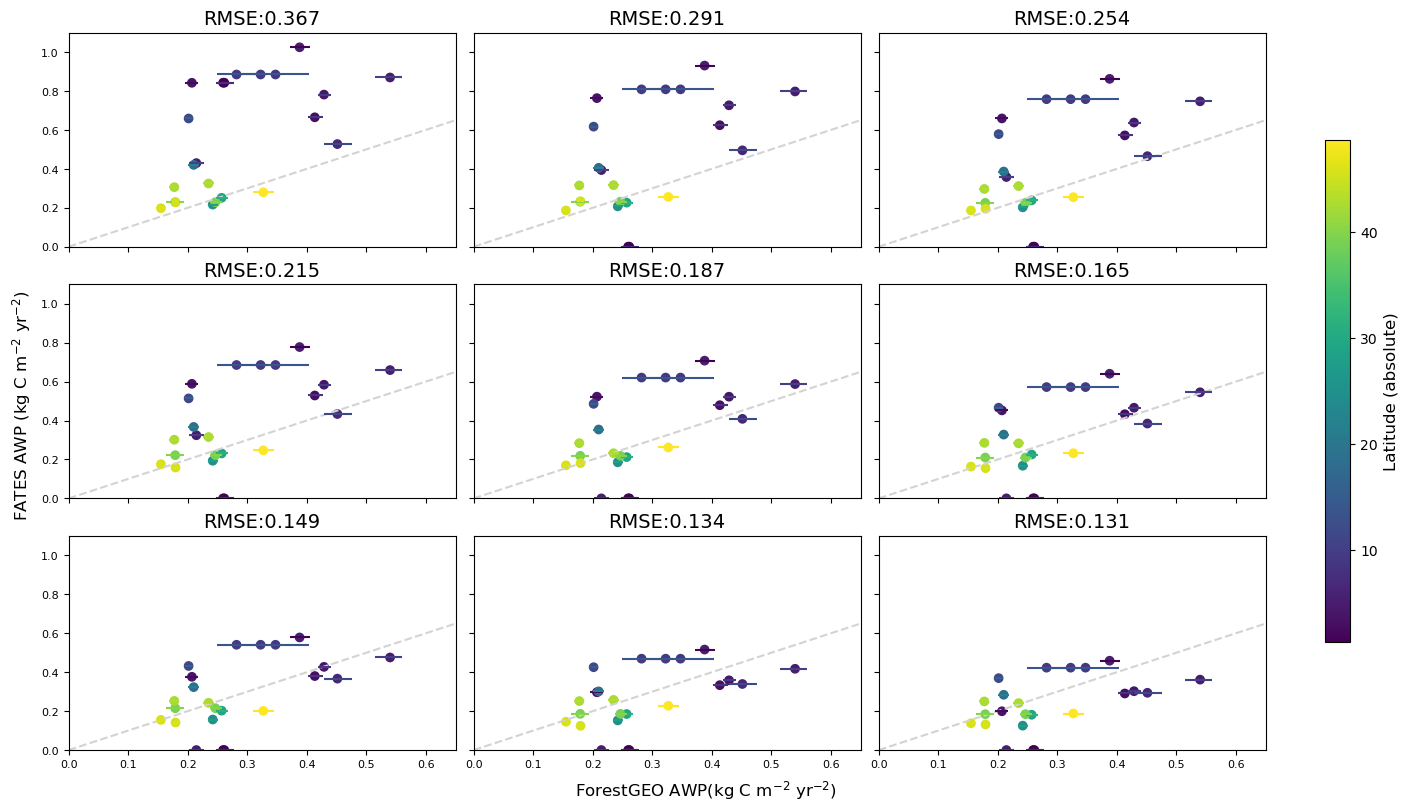

In [11]:
x = xr.DataArray(lat_ind, dims = ['location'])
y = xr.DataArray(lon_ind, dims = ['location'])

from matplotlib.colors import Normalize
cc = lat
cmap=cm.viridis
norm=Normalize(vmin=cc.min(),vmax=cc.max())

def rmse(predictions, targets):
    return np.sqrt(((predictions - targets) ** 2).mean())

fig, axs = plt.subplots(nrows=3,ncols=3, figsize=(14,8), constrained_layout=True, sharex=True, sharey=True)

axs=axs.flatten()

for i in range(0,ninst):
    
    awp = fates_runs[i].FATES_ABOVEGROUND_PROD_SZPF.isel(time=slice(tave_start,tave_stop)).mean(dim='time')
    awp = awp = awp.sum(dim='fates_levscpf') * 86400 * 365 # s-1 to yr-1
    fates_awp = awp.isel(lat=x,lon=y)
    
    root_mean_sq_err = rmse(fates_awp, plot_awp).values.round(3)
    
    # AWP 
    sc = axs[i].scatter(plot_awp, fates_awp, c=abs(lat), cmap='viridis')
    axs[i].set_title('RMSE:{0}'.format(root_mean_sq_err), x=0.5, y=1.0, fontsize = 14)
    axs[i].plot(np.linspace(0,0.7,10), np.linspace(0,0.7,10), color = 'lightgrey', linestyle='dashed')
    axs[i].tick_params(labelsize=8)
    axs[i].errorbar(plot_awp, fates_awp, xerr=[plot_awp_l, plot_awp_u],ecolor= cmap(norm(cc)), fmt='none')
    axs[i].set_ylim(0,1.1)
    axs[i].set_xlim(0,0.65)
      
fig.supxlabel(r'ForestGEO AWP(kg C m$^{-2}$ yr$^{-2}$)', fontsize=12)
fig.supylabel(r'FATES AWP (kg C m$^{-2}$ yr$^{-2}$)', fontsize=12)

# Add a colorbar 
cbar = fig.colorbar(sc, ax=axs[:],shrink=0.7)
cbar.set_label(r'Latitude (absolute)', fontsize=12)


### AWM 

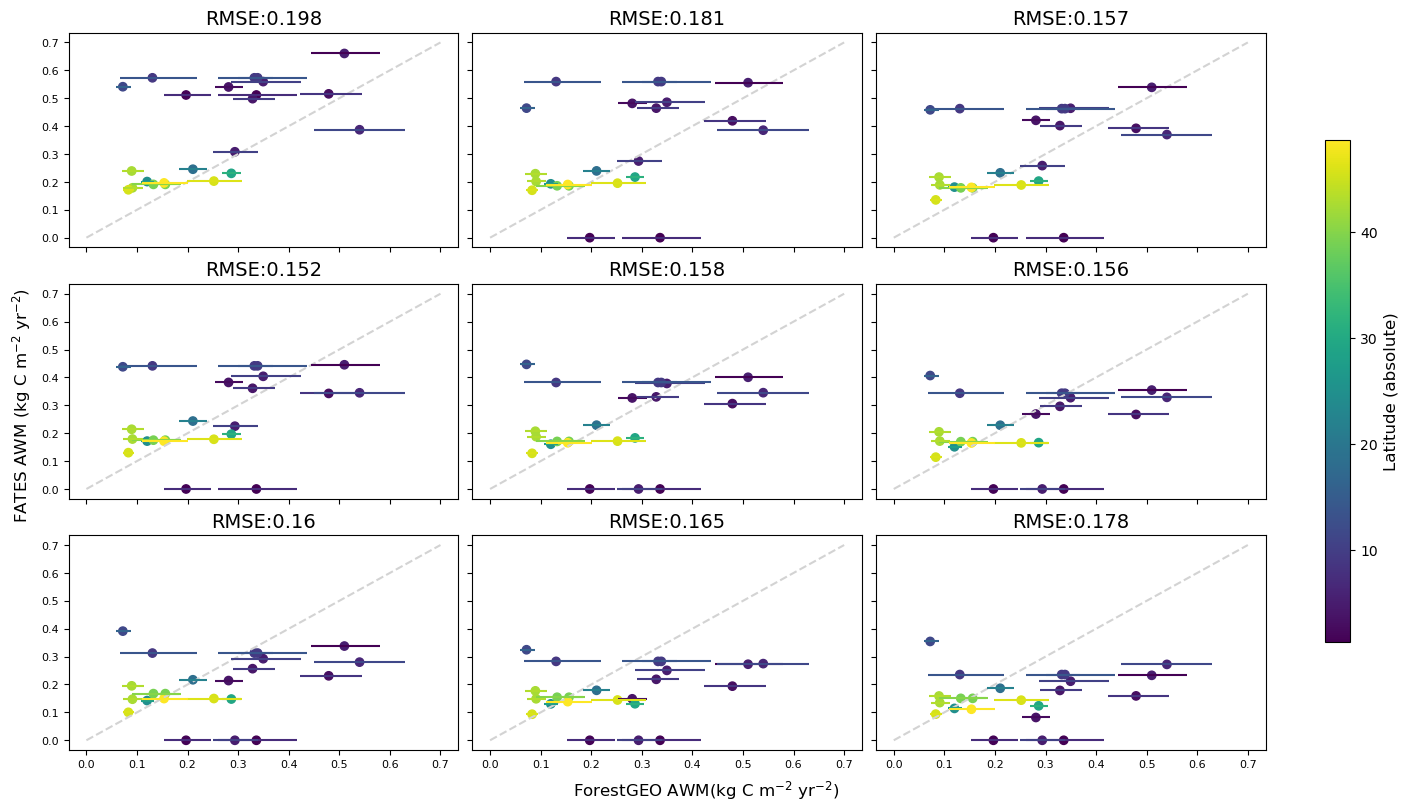

In [12]:
fig, axs = plt.subplots(nrows=3,ncols=3, figsize=(14,8), constrained_layout=True, sharex=True, sharey=True)

axs=axs.flatten()

for i in range(0,ninst):
    
    awm = fates_runs[i].FATES_ABOVEGROUND_MORT_SZPF.isel(time=slice(tave_start,tave_stop)).mean(dim='time')
    awm = awm.sum(dim='fates_levscpf') * 86400 * 365 # s-1 to yr-1
    fates_awm = awm.isel(lat=x,lon=y)
    
    root_mean_sq_err = rmse(fates_awm, plot_awm).values.round(3)
    
    # AWP 
    sc = axs[i].scatter(plot_awm, fates_awm, c=abs(lat), cmap='viridis')
    axs[i].set_title('RMSE:{0}'.format(root_mean_sq_err), x=0.5, y=1.0, fontsize = 14)
    axs[i].plot(np.linspace(0,0.7,10), np.linspace(0,0.7,10), color = 'lightgrey', linestyle='dashed')
    axs[i].tick_params(labelsize=8)
    axs[i].errorbar(plot_awm, fates_awm, xerr=[plot_awm_l, plot_awm_u],ecolor= cmap(norm(cc)), fmt='none')
     
fig.supxlabel(r'ForestGEO AWM(kg C m$^{-2}$ yr$^{-2}$)', fontsize=12)
fig.supylabel(r'FATES AWM (kg C m$^{-2}$ yr$^{-2}$)', fontsize=12)

# Add a colorbar 
cbar = fig.colorbar(sc, ax=axs[:],shrink=0.7)
cbar.set_label(r'Latitude (absolute)', fontsize=12)


### AGB

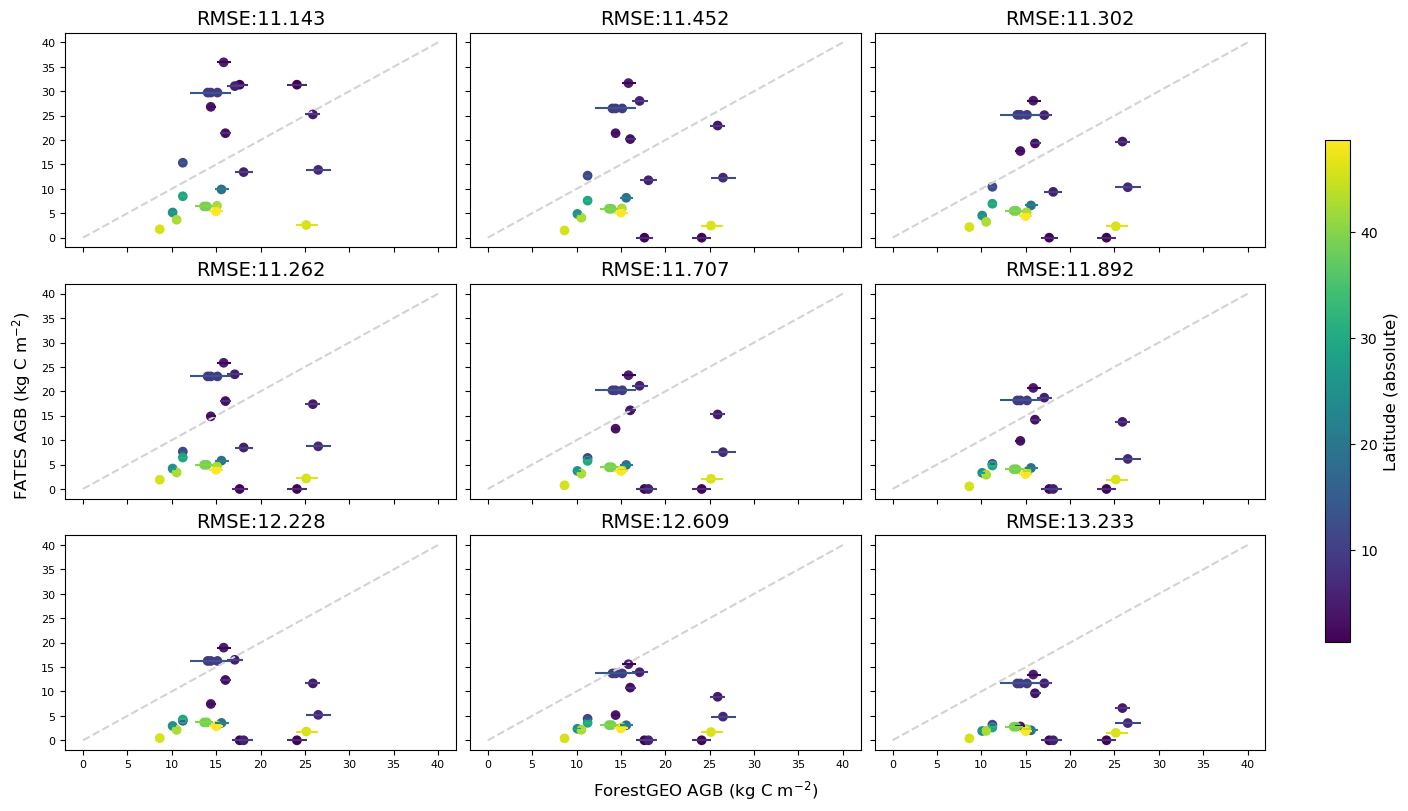

In [13]:
fig, axs = plt.subplots(nrows=3,ncols=3, figsize=(14,8), constrained_layout=True, sharex=True, sharey=True)

axs=axs.flatten()

for i in range(0,ninst):
    
    agb = fates_runs[i].FATES_VEGC_ABOVEGROUND.isel(time=slice(tave_start,tave_stop)).mean(dim='time')
    fates_agb = agb.isel(lat=x,lon=y)
    
    root_mean_sq_err = rmse(fates_agb, plot_agb).values.round(3)
    
    # AWP 
    sc = axs[i].scatter(plot_agb, fates_agb, c=abs(lat), cmap='viridis')
    axs[i].set_title('RMSE:{0}'.format(root_mean_sq_err), x=0.5, y=1.0, fontsize = 14)
    axs[i].plot(np.linspace(0,40,10), np.linspace(0,40,10), color = 'lightgrey', linestyle='dashed')
    axs[i].tick_params(labelsize=8)
    axs[i].errorbar(plot_agb, fates_agb, xerr=[plot_agb_l, plot_agb_u],ecolor= cmap(norm(cc)), fmt='none')
     
fig.supxlabel(r'ForestGEO AGB (kg C m$^{-2}$)', fontsize=12)
fig.supylabel(r'FATES AGB (kg C m$^{-2}$)', fontsize=12)

# Add a colorbar 
cbar = fig.colorbar(sc, ax=axs[:],shrink=0.7)
cbar.set_label(r'Latitude (absolute)', fontsize=12)


### AWP Galbraith et al. 2013 v FATES for each fates_base_mr_20

#### Load and format Galbraith plot data

In [14]:
df = pd.read_csv('/qfs/people/need138/plot_data/Galbraith_etal_2013_table_S1.csv')
#df.head(5)

# for plots with the same lat and lon use the mean of AGB, AWP and Tau
df['mean_AGB'] = df.groupby(['Lat','Lon'])['AGB (MgDM)'].transform('mean')
df['mean_AWP'] = df.groupby(['Lat','Lon'])['AWP (Mg DM year-1)'].transform('mean')
df['mean_tau'] = df.groupby(['Lat','Lon'])['Residence Time (years)'].transform('mean')

df = df.drop_duplicates(subset = ['Lat','Lon','mean_AGB'], keep = 'last').reset_index(drop=True)


lat = np.array(df['Lat'])
lon_negs = np.array(df['Lon'])
lon = [x%360 for x in lon_negs]


# AGB
plot_agb = np.array(df['mean_AGB'])
# Mg ha-1 of biomass to kg m-2 of Carbon  
plot_agb = plot_agb * 1000 / 10000 / 2 

# AWP
plot_awp = np.array(df['mean_AWP'])
# Mg ha-1 of biomass to kg m-2 of Carbon  
plot_awp = plot_awp * 1000 / 10000 / 2 

# tau
plot_tau = np.array(df['mean_tau'])

#### Find nearest FATES grid cells

In [15]:
n_plots=len(lat) # number of forestGEO sites
min_grids = np.empty((n_plots,2),int) # array to hold index of nearest grid cells for each plot

for k in range(0, n_plots) :
    min_grids[k,:] = find_nearest_grid(lat[k], lon[k], mid_lat, mid_lon, fates_frac)
    
# get indeces
lat_ind = min_grids[:,0]
lon_ind = min_grids[:,1]
    
# These are on a -90 to 90 and 0 to 360 scale
plot_mid_lats = mid_lat[lat_ind]
plot_mid_lons = mid_lon[lon_ind]

# Transform back to -90 to 90 and -180 to 180 for plotting
fig_plot_mid_lats = plot_mid_lats
fig_plot_mid_lons = [-1*(360-x) if x > 180 else x for x in plot_mid_lons]

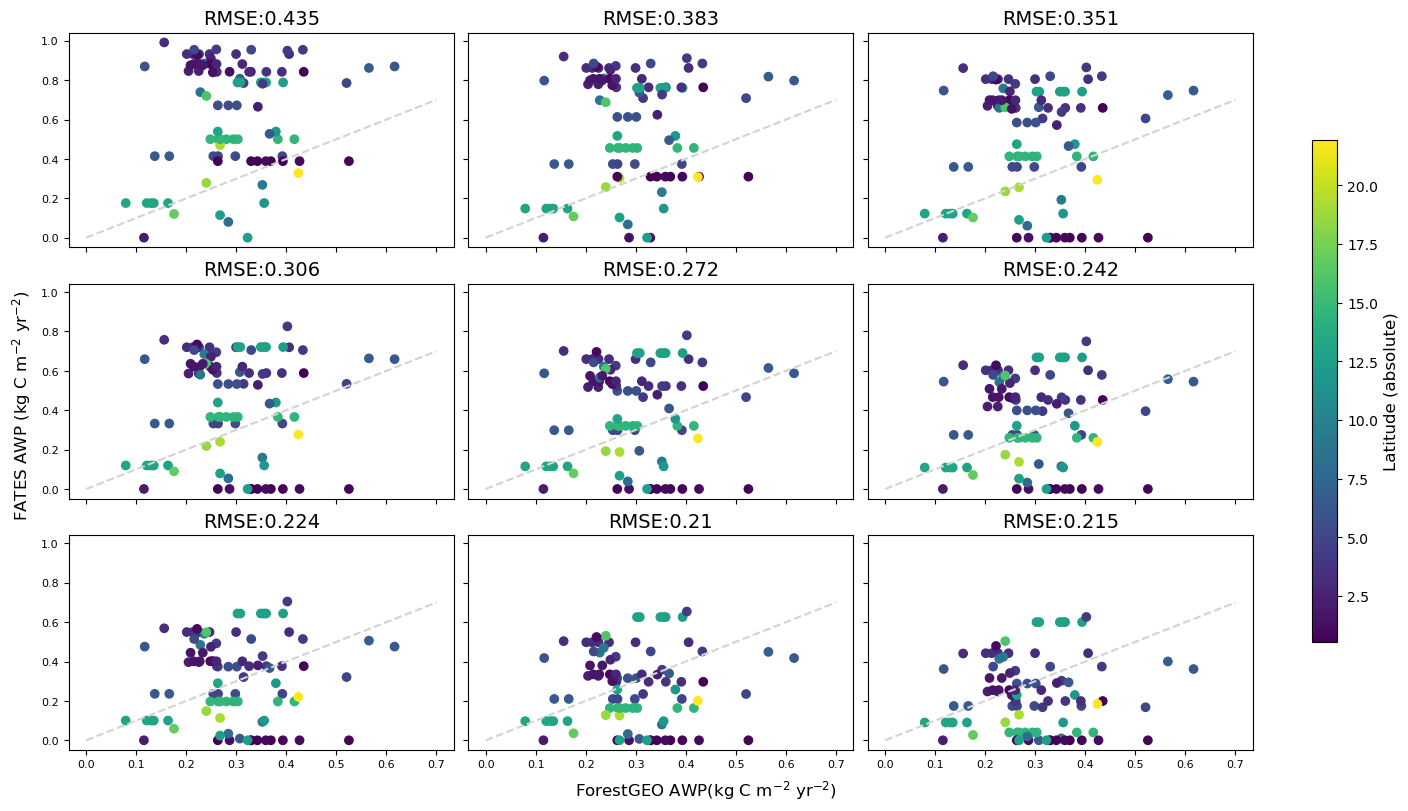

In [16]:
x = xr.DataArray(lat_ind, dims = ['location'])
y = xr.DataArray(lon_ind, dims = ['location'])

from matplotlib.colors import Normalize
cc = lat
cmap=cm.viridis
norm=Normalize(vmin=cc.min(),vmax=cc.max())


fig, axs = plt.subplots(nrows=3,ncols=3, figsize=(14,8),
                        constrained_layout=True, sharex=True, sharey=True)

axs=axs.flatten()

for i in range(0,ninst):
    
    awp = fates_runs[i].FATES_ABOVEGROUND_PROD_SZPF.isel(time=slice(tave_start,tave_stop)).mean(dim='time')
    awp = awp = awp.sum(dim='fates_levscpf') * 86400 * 365 # s-1 to yr-1
    fates_awp = awp.isel(lat=x,lon=y)
    
    root_mean_sq_err = rmse(fates_awp, plot_awp).values.round(3)
    #print(root_mean_sq_err)
    
    # AWP 
    sc = axs[i].scatter(plot_awp, fates_awp, c=abs(lat), cmap='viridis')
    axs[i].set_title('RMSE:{0}'.format(root_mean_sq_err), x=0.5, y=1.0, fontsize = 14)
    axs[i].plot(np.linspace(0,0.7,10), np.linspace(0,0.7,10), color = 'lightgrey', linestyle='dashed')
    axs[i].tick_params(labelsize=8)
      
fig.supxlabel(r'ForestGEO AWP(kg C m$^{-2}$ yr$^{-2}$)',fontsize=12)
fig.supylabel(r'FATES AWP (kg C m$^{-2}$ yr$^{-2}$)',fontsize=12)


# Add a colorbar 
cbar = fig.colorbar(sc, ax=axs[:],shrink=0.7)
cbar.set_label(r'Latitude (absolute)', fontsize=12)



### Carbon residence time

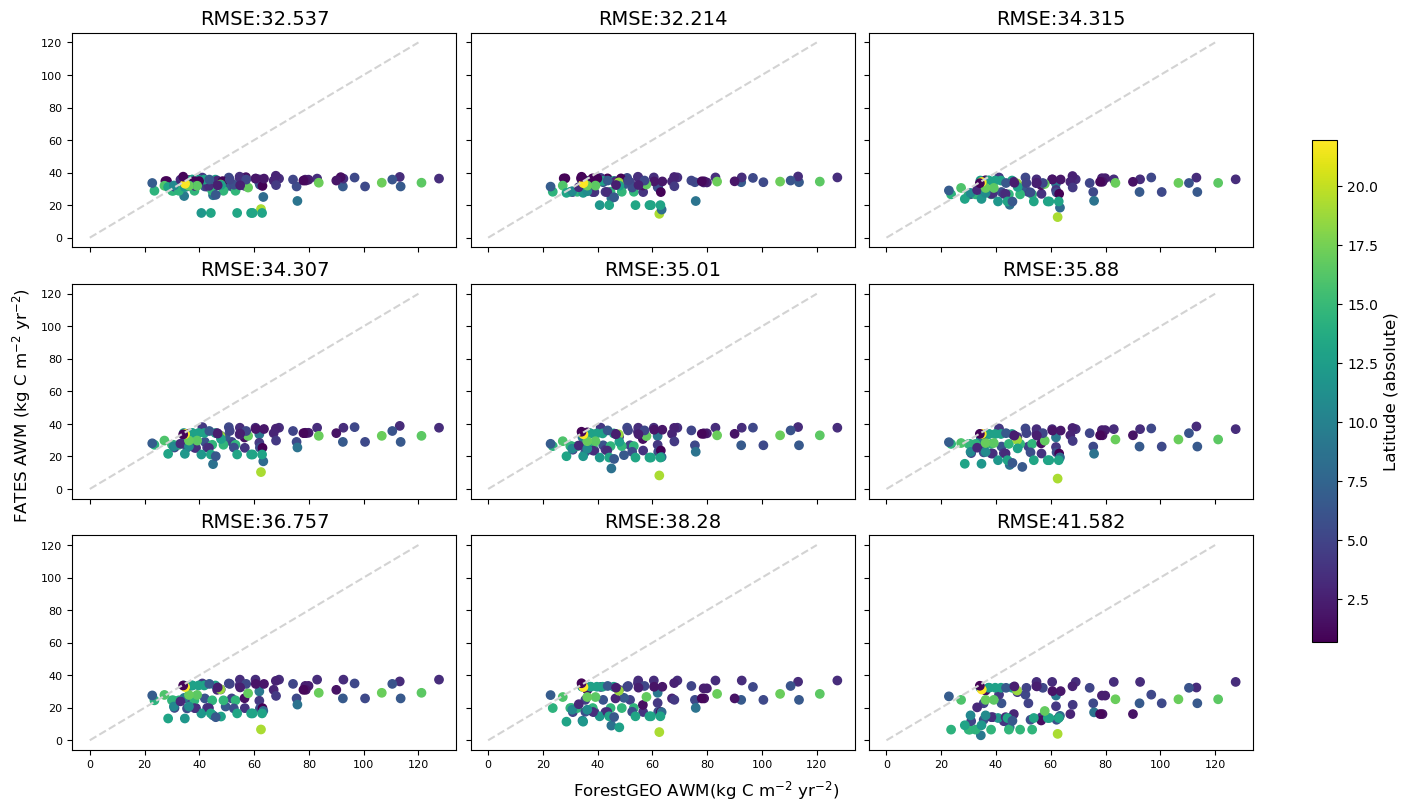

In [17]:
fig, axs = plt.subplots(nrows=3,ncols=3, figsize=(14,8),
                        constrained_layout=True, sharex=True, sharey=True)

axs=axs.flatten()

for i in range(0,ninst):
    
    awp = fates_runs[i].FATES_ABOVEGROUND_PROD_SZPF.isel(time=slice(tave_start,tave_stop)).mean(dim='time')
    awp = awp.sum(dim='fates_levscpf') * 86400 * 365 # s-1 to yr-1
    fates_awp = awp.isel(lat=x,lon=y)
    
    # AGB - total
    agb = fates_runs[i].FATES_VEGC_ABOVEGROUND.isel(time=slice(tave_start,tave_stop)).mean(dim='time')
    fates_agb = agb.isel(lat=x,lon=y)

    fates_tau = fates_agb/fates_awp
    
    root_mean_sq_err = rmse(fates_tau, plot_tau).values.round(3)
    #print(root_mean_sq_err)
    
    # AWP 
    sc = axs[i].scatter(plot_tau, fates_tau, c=abs(lat), cmap='viridis')
    axs[i].set_title('RMSE:{0}'.format(root_mean_sq_err), x=0.5, y=1.0, fontsize = 14)
    axs[i].plot(np.linspace(0,120,10), np.linspace(0,120,10), color = 'lightgrey', linestyle='dashed')
    axs[i].tick_params(labelsize=8)
     
fig.supxlabel(r'ForestGEO AWM(kg C m$^{-2}$ yr$^{-2}$)',fontsize=12)
fig.supylabel(r'FATES AWM (kg C m$^{-2}$ yr$^{-2}$)',fontsize=12)


# Add a colorbar 
cbar = fig.colorbar(sc, ax=axs[:],shrink=0.7)
cbar.set_label(r'Latitude (absolute)', fontsize=12)



### AGB

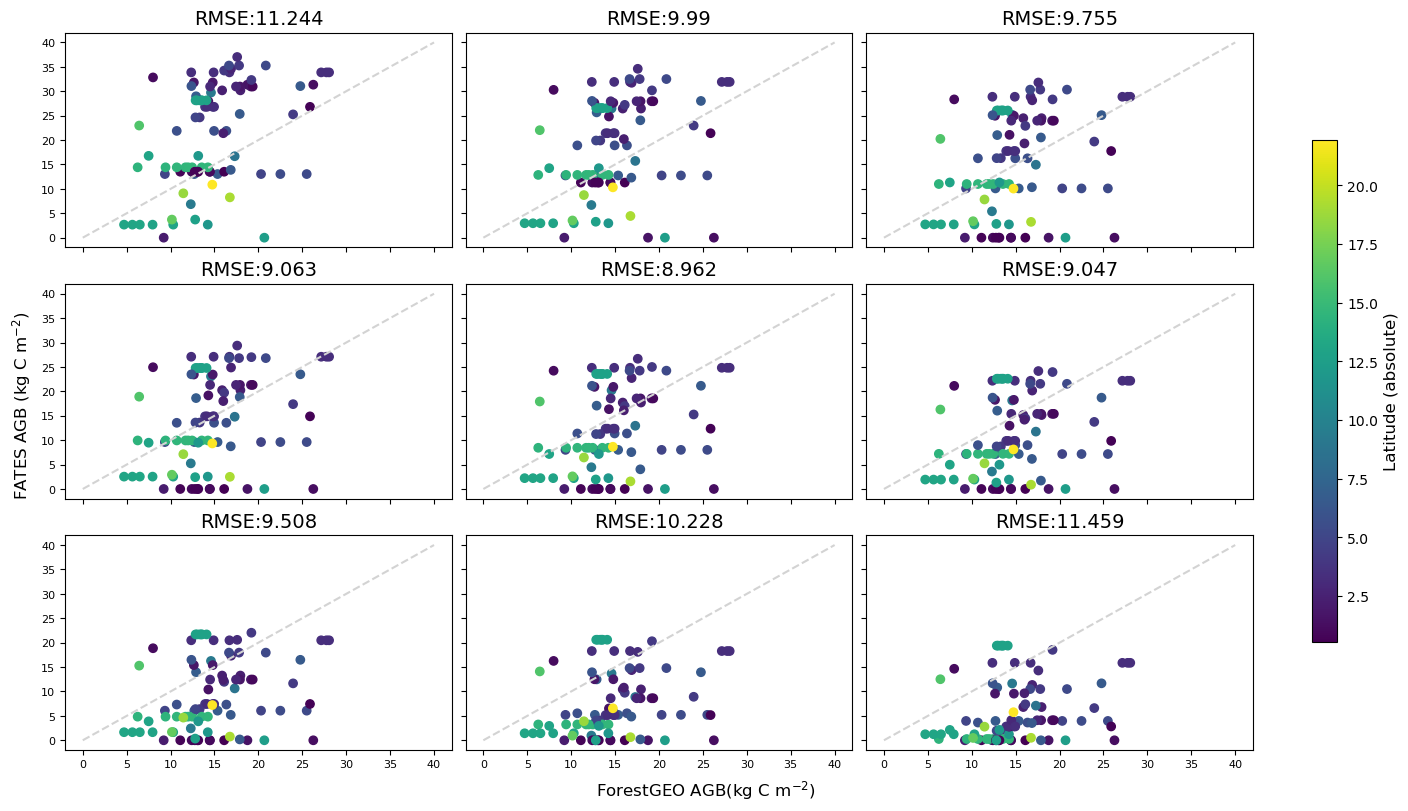

In [18]:
fig, axs = plt.subplots(nrows=3,ncols=3, figsize=(14,8),
                        constrained_layout=True, sharex=True, sharey=True)

axs=axs.flatten()

for i in range(0,ninst):
    
    # AGB - total
    agb = fates_runs[i].FATES_VEGC_ABOVEGROUND.isel(time=slice(tave_start,tave_stop)).mean(dim='time')
    fates_agb = agb.isel(lat=x,lon=y)

    root_mean_sq_err = rmse(fates_agb, plot_agb).values.round(3)
    #print(root_mean_sq_err)
    
    # AWP 
    sc = axs[i].scatter(plot_agb, fates_agb, c=abs(lat), cmap='viridis')
    axs[i].set_title('RMSE:{0}'.format(root_mean_sq_err), x=0.5, y=1.0, fontsize = 14)
    axs[i].plot(np.linspace(0,40,10), np.linspace(0,40,10), color = 'lightgrey', linestyle='dashed')
    axs[i].tick_params(labelsize=8)
     
fig.supxlabel(r'ForestGEO AGB(kg C m$^{-2}$)',fontsize=12)
fig.supylabel(r'FATES AGB (kg C m$^{-2}$)',fontsize=12)


# Add a colorbar 
cbar = fig.colorbar(sc, ax=axs[:],shrink=0.7)
cbar.set_label(r'Latitude (absolute)', fontsize=12)